In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn import tree

In [18]:
# Laddar upp datasetet. sep är för att tala om att det är delat med ;
dataSet = pd.read_csv('DataCSV.csv', sep=';', header =1)

In [19]:
# Tar bort alla deciamlkomma som störde ut hela filen
colsToDrop = [col for col in dataSet.columns if 'Unnamed' in col]
dataSet = dataSet.drop(columns=colsToDrop)

In [20]:
# Skriver ut allt å ser så det är bra.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print (dataSet)

      SFH  popUpWidnow  SSLfinal_State  Request_URL  URL_of_Anchor  \
0       1           -1               1           -1             -1   
1      -1           -1              -1           -1             -1   
2       1           -1               0            0             -1   
3       1            0               1           -1             -1   
4      -1           -1               1           -1              0   
5      -1           -1               1           -1             -1   
6       1           -1               0            1             -1   
7       1            0               1            1              0   
8      -1           -1               0           -1             -1   
9      -1            0              -1           -1              1   
10     -1           -1               0           -1             -1   
11      1            0               1            1              1   
12      1           -1               0           -1              1   
13      1           

In [21]:
# Dela upp datan i target(y) och alla futeres(x) som den ska tränas på. 

# *** Orginaldata
targetColumn = 'Resultat'
y = dataSet[targetColumn]
x = dataSet.drop(targetColumn, axis=1)




In [22]:
# Skriver ut de olka dataseten
print("Orginaldata:                      dataSet")


print("Target data Orginal:              y")
print("FuturesData Orginal:              x")
print()


Orginaldata:                      dataSet
Target data Orginal:              y
FuturesData Orginal:              x



In [23]:
# Vi skapar listor för att spara resultaten av de 100  första körningarna. accuracy, precision, recall, och f1 score
# Orginal med 90/10
resultTestOne = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1Score": []
    }

# Behöver skapa en tom matris som vi kan lägga in resultaten i för confusion matrix.
# Antal klasser (-1, 0, 1) 
numClasses = 3 

# Matris som summerar 100 iterationer
summorizedMatrix = np.zeros((numClasses, numClasses), dtype=int)

In [24]:
# Nu ska vi köra första loopen med orginladatan och 90/10 fördelning.

# Först loopen
for i in range(100):
    # Delning träning/testdata
    xTrain, xTest, yTrain, yTest  = train_test_split(x, y, test_size= 0.1, random_state=None)
    
    # Vi Tränar modellen
    model = DecisionTreeClassifier(random_state=123)
    model.fit(xTrain, yTrain)

    # Vi prediktar värden på testdatan
    predictions = model.predict(xTest)

    # För att köra confusion matrix behövs konvertering till index 0,1,2
    yTestIndexed = yTest + 1
    predictionsIndexed = predictions + 1

    # Beräkna matrix för denna loop
    matrixCurrent = confusion_matrix(yTestIndexed, predictionsIndexed, labels=range(numClasses))

    # Summera Matrix
    summorizedMatrix += matrixCurrent

    # Skapar rapporten och plockar ut datan. "out_put=True" = Returnerar rapporten som en dictionary istället för
    # att skriva ut den direkt. 
    report = classification_report(yTest, predictions, output_dict=True)

    # Sparar resultatetn från varje varv.
    resultTestOne["accuracy"].append(report['accuracy'])
    resultTestOne["precision"].append(report['weighted avg']['precision'])
    resultTestOne["recall"].append(report['weighted avg']['recall'])
    resultTestOne["f1Score"].append(report['weighted avg']['f1-score'])
    
#Skriver ut att loopen är klar
print("100 körningar gjorda.")

100 körningar gjorda.


In [25]:
# Då ska vi beräkna medelvärdena för resultaten
meanAccuracy = np.mean(resultTestOne["accuracy"])
meanPrecision = np.mean(resultTestOne["precision"])
meanRecall = np.mean(resultTestOne["recall"])
meanF1 = np.mean(resultTestOne["f1Score"])

# Skriv ut och presentera
print("Medelvärden för Orginaldata med 90/10 fördelning")
print()
print(f"Medel Accuracy: {meanAccuracy:.2f}")
print(f"Medel Precision: {meanPrecision:.2f}")
print(f"Medel Recall: {meanRecall:.2f}")
print(f"Medel F1-Score: {meanF1:.2f}")

Medelvärden för Orginaldata med 90/10 fördelning

Medel Accuracy: 0.88
Medel Precision: 0.88
Medel Recall: 0.88
Medel F1-Score: 0.88


In [26]:
print("Skriver ut en summerad confusion matrix")
print()
print(summorizedMatrix)

Skriver ut en summerad confusion matrix

[[6442  111  581]
 [  96  864   60]
 [ 660  134 4652]]


In [ ]:
# Bara AI, lär och förstå
# import numpy as np - Lagt upp, ta bort?
# from sklearn.metrics import precision_recall_fscore_support - Lagt upp, ta bort?

# Din summerade Confusion Matrix
# Obs: Använd 0-indexering för att matcha klasserna Legitimt (0), Misstänkt (1), Phishing (2)
summorizedMatrix = np.array([
    [6442, 111, 581],
    [96, 864, 60],
    [660, 134, 4652]
])

# 1. Hämta TP, FN, FP för varje klass från matrisen.
# True Positives (TP) = Diagonalen i matrisen
TP = np.diag(summorizedMatrix)

# False Negatives (FN) = Summan av varje rad minus TP
FN = np.sum(summorizedMatrix, axis=1) - TP

# False Positives (FP) = Summan av varje kolumn minus TP
FP = np.sum(summorizedMatrix, axis=0) - TP

# 2. Skapa "fake" sanna värden (y_true) och prediktioner (y_pred)
# Denna funktion tar faktiskt inte direkt en summerad matris.
# Istället använder vi Scikit-learns inbyggda funktion för att beräkna 
# Precision, Recall och F1-score direkt från TP, FN och FP.

# precision_recall_fscore_support är designad för att användas på enskilda körningar.
# För aggregerade data är det bäst att använda de matematiska formlerna, 
# som Scikit-learn implementerar internt, men genom att mata in de aggregerade TP, FN, FP.

# Vi kan använda precision_recall_fscore_support genom att "simulera" de sanna 
# och predikterade värdena i en format som funktionen accepterar, 
# men det blir komplicerat. Vi håller oss till de matematiska formlerna 
# och använder NumPy för att göra beräkningarna automatiskt.

# 3. Beräkna måtten automatiskt med NumPy
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
support = np.sum(summorizedMatrix, axis=1) # Antal sanna instanser per klass

# 4. Presentera resultatet
target_names = ["Legitimt", "Misstänkt", "Phishing"]

print("Aggregerad Classification Report (100 körningar)")
print("-" * 55)
print("{:<10} {:>10} {:>10} {:>10} {:>10}".format("Klass", "Precision", "Recall", "F1-Score", "Support"))
print("-" * 55)

for i, name in enumerate(target_names):
    print("{:<10} {:>10.4f} {:>10.4f} {:>10.4f} {:>10}".format(
        name,
        precision[i],
        recall[i],
        f1_score[i],
        support[i]
    ))
print("-" * 55)

=== Linear SVM ===


NameError: name 'y_test' is not defined

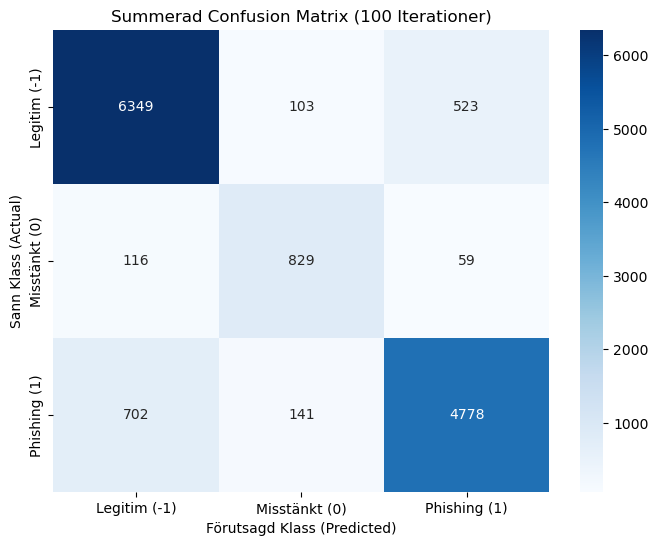

In [ ]:
# Presentera cm lite snyggare.

# Klassnamnen
classNames = ['Legitim (-1)', 'Misstänkt (0)', 'Phishing (1)' ]

# Gör figuren och axlarna
plt.figure(figsize=(8, 6))

# Gör en heatmap
sns.heatmap(summorizedMatrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=classNames, yticklabels=classNames)

# Lägger till etiketter och titel
plt.title('Summerad Confusion Matrix (100 Iterationer)')
plt.ylabel('Sann Klass (Actual)')
plt.xlabel('Förutsagd Klass (Predicted)')

plt.show()

In [ ]:
# Vi skapar listor för att spara resultaten av de 100  Andra körningarna. accuracy, precision, recall, och f1 score
# Orginal med 70/30
resultTestTwo = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1Score": []
    }

# Behöver skapa en tom matris som vi kan lägga in resultaten i för confusion matrix.
# Antal klasser (-1, 0, 1) 
numClasses = 3 

# Matris som summerar 100 iterationer
summorizedMatrix = np.zeros((numClasses, numClasses), dtype=int)

In [ ]:
# Nu ska vi köra Andra loopen med orginladatan och 70/30 fördelning.

# Först loopen
for i in range(100):
    # Delning träning/testdata
    xTrain, xTest, yTrain, yTest  = train_test_split(x, y, test_size= 0.1, random_state=None)
    
    # Vi Tränar modellen
    model = DecisionTreeClassifier(random_state=123)
    model.fit(xTrain, yTrain)

    # Vi prediktar värden på testdatan
    predictions = model.predict(xTest)

    # För att köra confusion matrix behövs konvertering till index 0,1,2
    yTestIndexed = yTest + 1
    predictionsIndexed = predictions + 1

    # Beräkna matrix för denna loop
    matrixCurrent = confusion_matrix(yTestIndexed, predictionsIndexed, labels=range(numClasses))

    # Summera Matrix
    summorizedMatrix += matrixCurrent

    # Skapar rapporten och plockar ut datan. "out_put=True" = Returnerar rapporten som en dictionary istället för
    # att skriva ut den direkt. 
    report = classification_report(yTest, predictions, output_dict=True)

    # Sparar resultatetn från varje varv.
    resultTestTwo["accuracy"].append(report['accuracy'])
    resultTestTwo["precision"].append(report['weighted avg']['precision'])
    resultTestTwo["recall"].append(report['weighted avg']['recall'])
    resultTestTwo["f1Score"].append(report['weighted avg']['f1-score'])
    
#Skriver ut att loopen är klar
print("100 körningar gjorda.")

100 körningar gjorda.


In [ ]:
# Då ska vi beräkna medelvärdena för resultaten
meanAccuracy = np.mean(resultTestTwo["accuracy"])
meanPrecision = np.mean(resultTestTwo["precision"])
meanRecall = np.mean(resultTestTwo["recall"])
meanF1 = np.mean(resultTestTwo["f1Score"])

# Skriv ut och presentera
print("Medelvärden för Orginaldata med 70/30 fördelning")
print()
print(f"Medel Accuracy: {meanAccuracy:.2f}")
print(f"Medel Precision: {meanPrecision:.2f}")
print(f"Medel Recall: {meanRecall:.2f}")
print(f"Medel F1-Score: {meanF1:.2f}")

Medelvärden för Orginaldata med 70/30 fördelning

Medel Accuracy: 0.88
Medel Precision: 0.88
Medel Recall: 0.88
Medel F1-Score: 0.88


In [ ]:
print("Skriver ut en summerad confusion matrix")
print()
print(summorizedMatrix)

Skriver ut en summerad confusion matrix

[[6382  106  559]
 [ 110  909   46]
 [ 692  127 4669]]


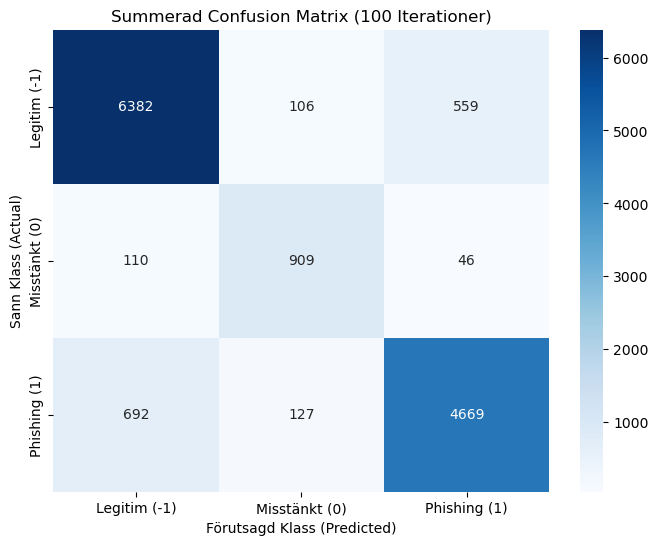

In [ ]:
# Presentera cm lite snyggare.

# Klassnamnen
classNames = ['Legitim (-1)', 'Misstänkt (0)', 'Phishing (1)' ]

# Gör figuren och axlarna
plt.figure(figsize=(8, 6))

# Gör en heatmap
sns.heatmap(summorizedMatrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=classNames, yticklabels=classNames)

# Lägger till etiketter och titel
plt.title('Summerad Confusion Matrix (100 Iterationer)')
plt.ylabel('Sann Klass (Actual)')
plt.xlabel('Förutsagd Klass (Predicted)')

plt.show()